In [10]:
%matplotlib inline

from pathlib import Path
import random

import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats import power

from matplotlib import pylab as plt
plt.style.use('default')

In [11]:
try:
    import common
    DATA = common.dataDirectory()
except ImportError:
    DATA = Path().resolve() / 'data'

In [12]:
WEB_PAGE_DATA_CSV = DATA / 'web_page_data.csv'
FOUR_SESSIONS_CSV = DATA / 'four_sessions.csv'
CLICK_RATE_CSV = DATA / 'click_rates.csv'
IMANISHI_CSV = DATA / 'imanishi_data.csv'

In [13]:
session_times = pd.read_csv(WEB_PAGE_DATA_CSV)
session_times.Time = 100 * session_times.Time
session_times.head()

,Page,Time
0,Page A,21.0
1,Page B,253.0
2,Page A,35.0
3,Page B,71.0
4,Page A,67.0


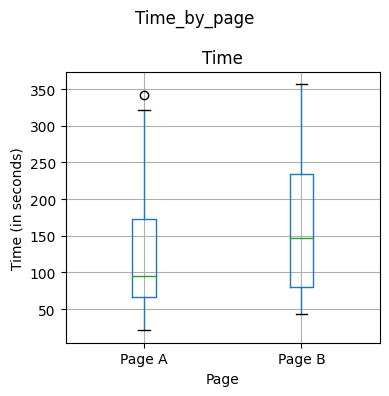

In [14]:
ax = session_times.boxplot(by = 'Page', column = 'Time', figsize = (4,4))
ax.set_xlabel('Page')
ax.set_ylabel('Time (in seconds)')
plt.suptitle('Time_by_page')
plt.tight_layout()
plt.show()

In [15]:
mean_a = session_times[session_times.Page == 'Page A']['Time'].mean()
mean_b = session_times[session_times.Page == 'Page B']['Time'].mean()
print(mean_b - mean_a)

35.66666666666667


In [16]:
# Permutation test example with stickness (웹점착성)
# We call it as "Randomization test" or "Random permutation test"
def perm_func(column, nA, nB):
    n = nA + nB
    # Randomly choose nB indices among population to groupB
    idx_B = set(random.sample(range(n), nB))
    # Assign the remained indices to groupA
    idx_A = set(range(n)) - idx_B
    # Subtract the mean values of two groups
    return column[list(idx_B)].mean() - column[list(idx_A)].mean()
    
nA = session_times[session_times.Page == 'Page A'].shape[0]
nB = session_times[session_times.Page == 'Page B'].shape[0]
print(perm_func(session_times.Time, nA, nB))

14.523809523809518


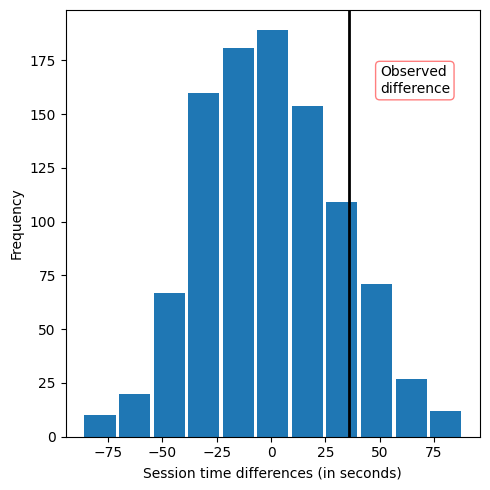

In [17]:
random.seed(0) # np.random.seed(0)
perm_diffs = [perm_func(session_times.Time, nA, nB) for _ in range(1000)]

fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_diffs, bins=11, rwidth=0.9)
ax.axvline(x = mean_b - mean_a, color='black', lw=2)
# bbox: 그래프에 추가된 text에 box를 씌우는 방법. 딕셔너리 형태로 입력
mybox={'facecolor':'white','edgecolor':'r','boxstyle':'round','alpha':0.5}
ax.text(50, 160, 'Observed\ndifference', bbox=mybox)
ax.set_xlabel('Session time differences (in seconds)')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [18]:
# perm_diffs > mean_b - mean_a 는 True와 False, 즉 1과 0의 리스트를 return 하므로
# 해당 리스트의 총합 / 총수, 즉 평균을 구하면 확률을 알 수 있음.
print(np.mean(perm_diffs > mean_b - mean_a))
# 결과는 A group과 B group간에 통계적으로 유의미한 차이가 있다고 할 수 없음.

0.133


# Statistical Significance and P-Values

[[  200 23739]
 [  182 22588]]
Observed difference: 0.0368%


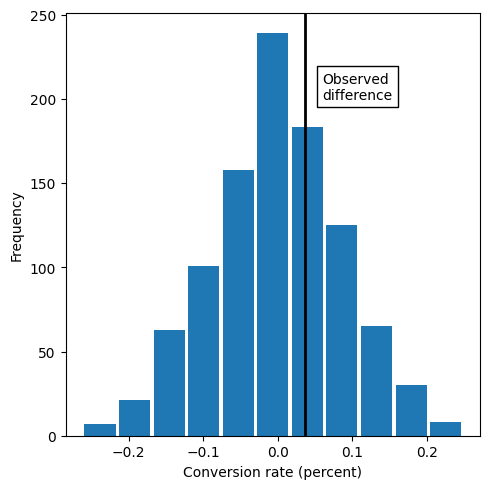

In [19]:
# 귀무가설: 가격A 와 가격B 사이에 전환의 차이가 없다.
# 대립가설: .. 차이가 있다.
print(np.array([[200, 23739],
         [182, 22588]]))
random.seed(1)
obs_pct_diff = 100 * (200 / 23739 - 182 / 22588)
print(f'Observed difference: {obs_pct_diff:.4f}%')

# 0과 1이 적힌 카드를 박스에 넣는다. 
conversion = [0] * 45945 # 23739 + 22588
conversion.extend([1] * 382) # 200 + 182
conversion = pd.Series(conversion) 

perm_diffs = [100 * perm_func(conversion, 23739, 22588)
              for _ in range(1000)]

fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_diffs, bins=11, rwidth=0.9)
ax.axvline(x=obs_pct_diff, color='black', lw=2)
ax.text(0.06, 200, 'Observed\ndifference', bbox={'facecolor':'white'})
ax.set_xlabel('Conversion rate (percent)')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [20]:
np.mean(np.array(perm_diffs) > obs_pct_diff)

0.332

In [23]:
# 해당 경우는 가설이 이항분포를 따르기 때문에, permutation을 하지 않고 p값을 근사할 수 있다.
# 독립성 검정과 일맥상통한다.
survivors = np.array([[200, 23739 - 200], [182, 22588 - 182]])
chi2, p_value, df, expected = stats.chi2_contingency(survivors)
print(f'p-value for single sided test: {p_value / 2:.4f}')
print(f'chi2: {chi2}')
print(f'df: {df}')
print(f'expected: {expected}')

p-value for single sided test: 0.3498
chi2: 0.14893055235461503
df: 1
expected: [[  195.74541844 23543.25458156]
 [  186.25458156 22401.74541844]]


# T-test

In [25]:
# t-test
res = stats.ttest_ind(session_times[session_times.Page == 'Page A'].Time, 
                      session_times[session_times.Page == 'Page B'].Time,
                      equal_var=False)
print(f'p-value for single sided test: {res.pvalue / 2:.4f}')

p-value for single sided test: 0.1408


In [26]:
tstat, pvalue, df = sm.stats.ttest_ind(
    session_times[session_times.Page == 'Page A'].Time, 
    session_times[session_times.Page == 'Page B'].Time,
    usevar='unequal', alternative='smaller')
print(f'p-value: {pvalue:.4f}')

p-value: 0.1408


# ANOVA

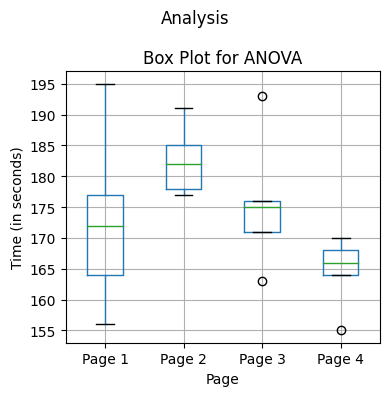

In [27]:
# ANOVA
four_sessions = pd.read_csv(FOUR_SESSIONS_CSV)
ax = four_sessions.boxplot(by = 'Page', column = 'Time', figsize = (4,4))
ax.set_xlabel('Page')
ax.set_ylabel('Time (in seconds)')
plt.suptitle('Analysis') # super title
plt.title('Box Plot for ANOVA')

plt.tight_layout()
plt.show()

In [34]:
four_sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Page    20 non-null     object
 1   Time    20 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 448.0+ bytes


In [35]:
observed_variance = four_sessions.groupby('Page').mean().var()[0]
print('Observed means:', four_sessions.groupby('Page').mean().values.ravel())
print('Variance:', observed_variance)
def perm_test(df):
    df = df.copy()
    df['Time'] = np.random.permutation(df['Time'].values)
    return df.groupby('Page').mean().var()[0]

perm_variance = [perm_test(four_sessions) for _ in range(3000)]
print('Pr(Prob)', np.mean([var > observed_variance for var in perm_variance]))

Observed means: [172.8 182.6 175.6 164.6]
Variance: 55.426666666666655
Pr(Prob) 0.06733333333333333


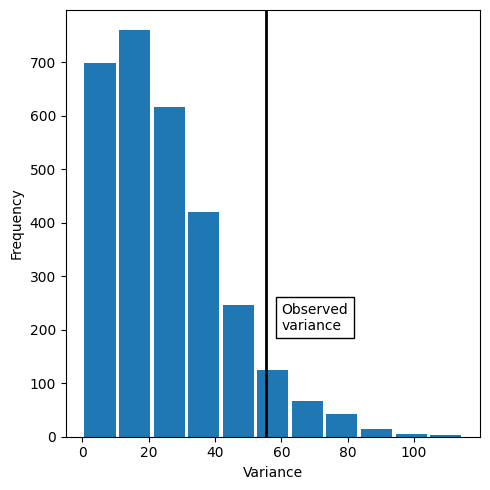

In [36]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_variance, bins=11, rwidth=0.9)
ax.axvline(x = observed_variance, color='black', lw=2)
ax.text(60, 200, 'Observed\nvariance', bbox={'facecolor':'white'})
ax.set_xlabel('Variance')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# F-Statistic
We can compute an ANOVA table using statsmodel.

Just like we have used t-test when comparing means between groups:
we can use F-statistic instead of permutation.

In [37]:
# About smf.ols: https://xiang32.tistory.com/13
model = smf.ols('Time ~ Page', data=four_sessions).fit()
anova_table = sm.stats.anova_lm(model)
print(anova_table)

            df  sum_sq     mean_sq         F    PR(>F)
Page       3.0   831.4  277.133333  2.739825  0.077586
Residual  16.0  1618.4  101.150000       NaN       NaN


In [38]:
res = stats.f_oneway(four_sessions[four_sessions.Page == 'Page 1'].Time, 
                     four_sessions[four_sessions.Page == 'Page 2'].Time,
                     four_sessions[four_sessions.Page == 'Page 3'].Time,
                     four_sessions[four_sessions.Page == 'Page 4'].Time)
print(f'F-Statistic: {res.statistic / 2:.4f}')
print(f'p-value: {res.pvalue / 2:.4f}')

F-Statistic: 1.3699
p-value: 0.0388


# Two way anova only available with statsmodels
```
formula = 'len ~ C(supp) + C(dose) + C(supp):C(dose)'

model = ols(formula, data).fit()

aov_table = anova_lm(model, typ=2)
```

# Chi-Square Test
# Chi-Square Test: A Resampling Approach

In [40]:
# Chi-square test - using permutation
click_rate = pd.read_csv(CLICK_RATE_CSV)
clicks = click_rate.pivot(index='Click', columns='Headline', values='Rate')
clicks

Headline,Headline A,Headline B,Headline C
Click,,,
Click,14,8,12
No-click,986,992,988


In [59]:
# Table 3-5
row_average = clicks.mean(axis=1)
pd.DataFrame({
    'Headline A': row_average,
    'Headline B': row_average,
    'Headline C': row_average,
})

,Headline A,Headline B,Headline C
Click,,,
Click,11.333333,11.333333,11.333333
No-click,988.666667,988.666667,988.666667


In [50]:
# Resampling approach
box = [1] * clicks.sum(axis = 1)[0] # 34
box.extend([0] * clicks.sum(axis = 1)[1]) # 2966
random.shuffle(box)

def chi2(observed, expected):
    # 피어슨 잔차
    pearson_residuals = []
    for row, expect in zip(observed, expected):
        pearson_residuals.append([(observe - expect) ** 2 / expect
                                  for observe in row])
    # return sum of squares
    return np.sum(pearson_residuals)

expected_clicks = 34 / 3
expected_noclicks = 1000 - expected_clicks
expected = [34 / 3, 1000 - 34 / 3]
chi2observed = chi2(clicks.values, expected)

def perm_fun(box):
    sample_clicks = [sum(random.sample(box, 1000)),
                     sum(random.sample(box, 1000)),
                     sum(random.sample(box, 1000))]
    sample_noclicks = [1000 - n for n in sample_clicks]
    return chi2([sample_clicks, sample_noclicks], expected)

perm_chi2 = [perm_fun(box) for _ in range(2000)]

resampled_p_value = np.mean(perm_chi2 > chi2observed)
print(f'Observed chi2: {chi2observed:.4f}')
print(f'Resampled p-value: {resampled_p_value:.4f}')

Observed chi2: 1.6659
Resampled p-value: 0.4820


In [53]:
# 점근적 통계이론은 카이제곱통계량의 분포가 카이제곱분포로 근사화될 수 있음을 보여준다.
chisq, pvalue, df, expected = stats.chi2_contingency(clicks)
print('Expected Value Array:\n', expected)
print(f'Observed chi2: {chi2observed:.4f}')
print(f'p-value: {pvalue:.4f}')

Expected Value Array:
 [[ 11.33333333  11.33333333  11.33333333]
 [988.66666667 988.66666667 988.66666667]]
Observed chi2: 1.6659
p-value: 0.4348


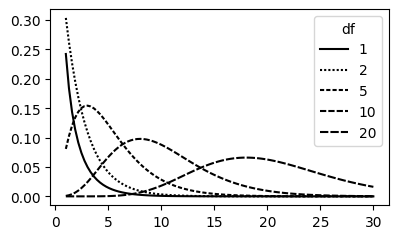

In [83]:
x = [1 + i * (30 - 1) / 99 for i in range(100)]

chi = pd.DataFrame({
    'x': x,
    'chi_1': stats.chi2.pdf(x, df=1),
    'chi_2': stats.chi2.pdf(x, df=2),
    'chi_5': stats.chi2.pdf(x, df=5),
    'chi_10': stats.chi2.pdf(x, df=10),
    'chi_20': stats.chi2.pdf(x, df=20),
})
fig, ax = plt.subplots(figsize=(4, 2.5))
ax.plot(chi.x, chi.chi_1, color='black', linestyle='-', label='1')
ax.plot(chi.x, chi.chi_2, color='black', linestyle=(0, (1, 1)), label='2')
ax.plot(chi.x, chi.chi_5, color='black', linestyle=(0, (2, 1)), label='5')
ax.plot(chi.x, chi.chi_10, color='black', linestyle=(0, (3, 1)), label='10')
ax.plot(chi.x, chi.chi_20, color='black', linestyle=(0, (4, 1)), label='20')
ax.legend(title='df')

plt.tight_layout()
plt.show()

In [85]:
# 피셔의 정확검정

# Power and Sample Size
statsmodels has a number of methods for power calculation

see e.g.: https://machinelearningmastery.com/statistical-power-and-power-analysis-in-python/

In [55]:
# Power and sample size
effect_size = sm.stats.proportion_effectsize(0.0121, 0.011)
analysis = sm.stats.TTestIndPower()
result = analysis.solve_power(effect_size=effect_size, 
                              alpha=0.05, power=0.8, alternative='larger')
print('Sample Size: %.3f' % result)

Sample Size: 116602.393


In [56]:
effect_size = sm.stats.proportion_effectsize(0.0165, 0.011)
analysis = sm.stats.TTestIndPower()
result = analysis.solve_power(effect_size=effect_size, 
                              alpha=0.05, power=0.8, alternative='larger')
print('Sample Size: %.3f' % result)

Sample Size: 5488.408
